# Импорт и настройка

In [347]:
! pip install mlxtend

In [348]:
import pandas as pd
from pandas import Series
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import scipy.stats as st
import numpy as np
import math
sns.set(style = 'dark')

from numpy import percentile
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import warnings

import os

warnings.filterwarnings("ignore")

In [349]:
RANDOM_SEED = 42
!pip freeze > requirements.txt


In [350]:
# этот блок используется на kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# этот блок используется на локальной машине
# PATH_to_file = ''

# **Функции**

In [351]:
def plot_confusion_matrix(y_true, y_pred, font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j] + '\n' + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def confusion_matrix_f(columns, d_y, d_y_pred, font_scale=1, normalize=False):
    class_names = np.array(columns, dtype='U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names,
                          title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names, normalize=True,
                              title='Нормализованная матрица ошибок')

    plt.show()
    return


def PR_curve_with_area(d_y_true, d_y_pred_prob, font_scale=1):
    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)

    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return


def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color='darkblue')
    plt.plot([0, num_folds - 1], [avg_metric_train, avg_metric_train], color='blue',
             label='среднее трен. значений ', marker='.', lw=2, ls='--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color='red')
    plt.plot([0, num_folds - 1], [avg_metric_test, avg_metric_test], color='lightcoral',
             label='среднее тест. значений ', marker='.', lw=2, ls='--')

    plt.plot([0, num_folds - 1], [d_value_metric, d_value_metric], color='grey',
             label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train, avg_metric_test) + 1.5 * max(std_metric_train, std_metric_test)
    y_min = min(avg_metric_train, avg_metric_test) - 3 * max(std_metric_train, std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color=color_text)
    plt.ylabel(d_name_metric, fontsize=15, color=color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах',
              color=color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min + 0.5 * max(std_metric_train, std_metric_test)
    plt.text(0, y_min_text,
             f'{d_name_metric} на трейне = {round(avg_metric_train, 3)} +/- '
             f'{round(std_metric_train, 3)} \n{d_name_metric} на тесте    = {round(avg_metric_test, 3)} +/- '
             f'{round(std_metric_test, 3)} \n{d_name_metric} до CV        = {round(d_value_metric, 3)}',
             fontsize=15)
    plt.show()
    return


def model_coef(d_columns, d_model_coef_0):
    temp_dict = {}
    temp_dict['имя признака'] = d_columns
    temp_dict['коэффициент модели'] = d_model_coef_0
    temp_dict['модуль коэф'] = abs(temp_dict['коэффициент модели'])
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='columns')
    temp_df = temp_df.sort_values(by='модуль коэф', ascending=False)
    temp_df.reset_index(drop=True, inplace=True)

    return temp_df.loc[:, ['имя признака', 'коэффициент модели']]

def print_metrics():
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('F1: %.4f' % f1_score(y_test, y_pred))

def ROC_curve_with_area(d_y_true, d_y_pred_prob, font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

### Описание столбцов¶
* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг наличия иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия "хорошей" работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_addreess - категоризатор рабочего адреса
* income - доход заемщика
* sna - свзяь заемщика с клиентами банка
* first_time - давность наличия информации из БКИ
* foreign_passport - наличие загранпаспорта
* default - наличие дефолта

In [352]:
# Предварительная загрузка и просмотр

data = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [353]:
# Импортируем данные

df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)

print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))

print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [354]:
display("train: shape" + str(df_train.shape), df_train.columns)
display("test: shape" +str(df_test.shape), df_test.columns)

# Видим, что в тестовой выборке нет данных признака "default", что логично.

'train: shape(73799, 19)'

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

'test: shape(36349, 18)'

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

In [355]:
# Делаем пометку, где тренировочная выборка, где тестовая
df_train['train'] = 1
df_test['train'] = 0

#Заранее сохраняем значения client_id для предсказания тестовой выборки
id_test = df_test['client_id']

dt =pd.DataFrame()
# объединяем датафреймы
df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем датафреймы
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


# Преобразование и чистка данных

In [356]:
#определим отсутствующие данные
def nan_in_table(df):
    x = pd.DataFrame()
    x['Всего NaN'] = df.isna().sum()
    x['% NaN'] = round((x['Всего NaN'] / df.shape[0])*100, 2)
       
    return x.sort_values('% NaN', ascending=False)

nan_in_table(df).head(5)

,Всего NaN,% NaN
default,36349,33.00
education,478,0.43
client_id,0,0.00
region_rating,0,0.00
foreign_passport,0,0.00


Значения отсутствуют в двух столбцах, но по факту для нас значимым является столбец education. Для заполнения пропусков воспользуемся встроенным модулем scikitlearn KNNImputer.

In [357]:
train_knn = df[['education']]
imputer = KNNImputer(n_neighbors = 9)

# создаем словарь из списка типов образования (0 -самое популярной, школьное и т.д.)
edu = df.education.value_counts().index.to_list() 
edu_dict = {}
for counter, edu_word in enumerate(edu):
    edu_dict[edu_word] = counter

train_knn['education'].replace(edu_dict, inplace=True)
df_fill = imputer.fit_transform(train_knn)
df.loc[:, 'education'] = np.round(df_fill.T[0],0).astype(int)

In [358]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

print(f'Начало периода: {df.app_date.min()}')
print(f'Конец периода: {df.app_date.max()}')

Начало периода: 2014-01-01 00:00:00
Конец периода: 2014-04-30 00:00:00


Данные к сожалению даны были всего за 4 месяца, этого не достаточно чтобы создать признак кварталов, поэтому будем считать дни от начала года 

In [359]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')
df.drop('app_date', axis = 1, inplace = True)
df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,days
0,25905,0,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1,31
1,63161,0,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1,70
2,25887,0,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1,31
3,16222,0,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1,22
4,101655,1,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0,89
110144,106254,1,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0,114
110145,81852,1,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0,88
110146,1971,2,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0,6


In [360]:
def bar_count(column, header=True):
    fig = plt.figure(figsize=(6,6))
    sns.set_style('whitegrid')  
    if header == True:
        sns.countplot(x=column, data=df, hue=column, dodge=0, color='green')
    else:
        sns.countplot(x=column, data=df, dodge=0, color='green')
    
    val = []
    for i in df[column].value_counts():
        val.append(round((i/df[column].shape[0])*100,2))

    res = {}
    for i,j in zip(df[column].value_counts().index, val):
        res[i] = j

    for i in res.items():
        print(f'{i[0]} : {i[1]}%')

In [361]:
def emissions_analys(column):

    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    start_int = perc25 - 1.5*IQR
    stop_int = perc75 + 1.5*IQR

    top_count = 0
    bot_count = 0

    for i in df[column]:
        if i > stop_int:
            top_count += 1
        elif i < start_int:
            bot_count += 1
        else:
            pass

    res = bot_count + top_count
    
    print(f'Минимальное значение: {df[column].min()} |', f'Максимальное значение: {df[column].max()}', 
          f'Среднее значение: {int(df[column].mean())}')
    print(60*'==')
    print(f'25-й перцентиль: {perc25} |', f'75-й перцентиль: {perc75} |', 
          f'Границы выбросов: [{start_int}, {stop_int}]')
    print(60*'==')
    print(f'Всего выбросов: {res} |', f'Выбросы в нижней границе: {bot_count} |', 
          f'Выбросы в верхней границе: {top_count}')

In [362]:
def distplot(df, column, bins=10):
    fig = plt.figure(figsize=(6,6))
    sns.set_style('whitegrid') 
    plot = sns.distplot(df[column],color='green', bins=bins)
    plt.show()

### Education - уровень образования
* 0 - SCH - школа
* 1 - UGR - кандидат в бакалавры
* 2 - GRD - бакалавр
* 3 - PRG - магистр
* 4 - ACD - академик

0 : 52.65%
1 : 32.0%
2 : 13.39%
3 : 1.69%
4 : 0.26%


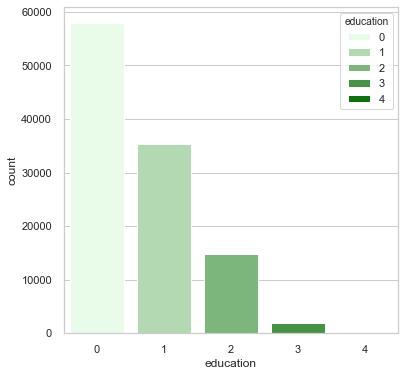

In [363]:
bar_count('education')

Большинство заемщиков - люди только со школьным образованием. Людей с высшим образованием (бакалавры, кандидаты в бакалавр и магистры ) - почти половина. Академиков меньше 1%. Также у нас есть пропуски в данных (478). Заполним их при помощи KNN и приведем столбец к числовому виду.

### Sex - пол заемщика¶
* M - мужчины
* F - женщины

F : 56.14%
M : 43.86%


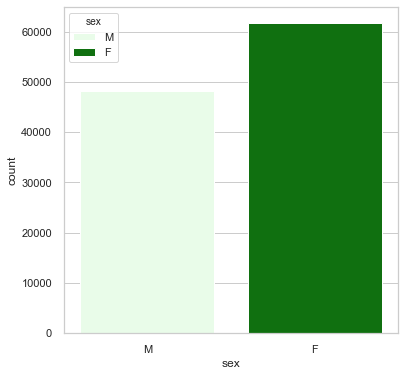

In [364]:
bar_count('sex')

Женщины берут заём немного чаще.

### Age - возраст заемщика

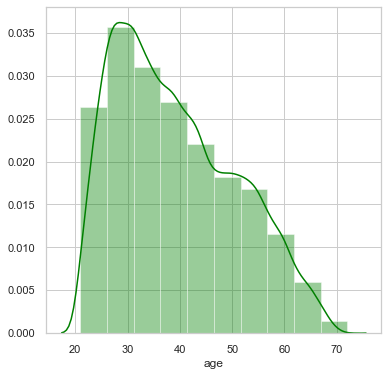

In [365]:
distplot(df,'age')

In [366]:
emissions_analys('age')

Минимальное значение: 21 | Максимальное значение: 72 Среднее значение: 39
25-й перцентиль: 30.0 | 75-й перцентиль: 48.0 | Границы выбросов: [3.0, 75.0]
Всего выбросов: 0 | Выбросы в нижней границе: 0 | Выбросы в верхней границе: 0


Минимальный возраст - 21 год, максимальный - 72 года. Средний около 37 лет. Выбросов нет. Распредение логнормлаьное. Прологарифмируем данный столбец

In [367]:
dt['age'] = np.log(df['age'] + 1)

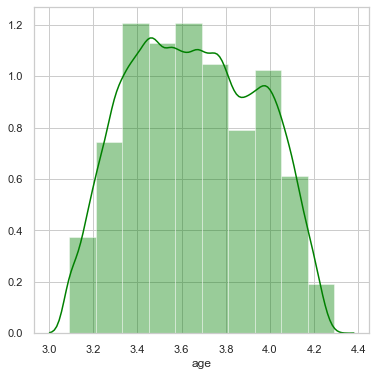

In [368]:
distplot(dt, 'age')

### Сar - наличие автомобиля
* Y - есть
* N - нет

N : 67.45%
Y : 32.55%


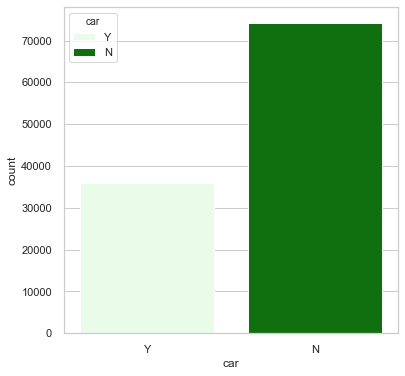

In [369]:
bar_count('car')

У большинства заемщиков нет автомобиля

### Car_type - наличие иномарки

N : 80.93%
Y : 19.07%


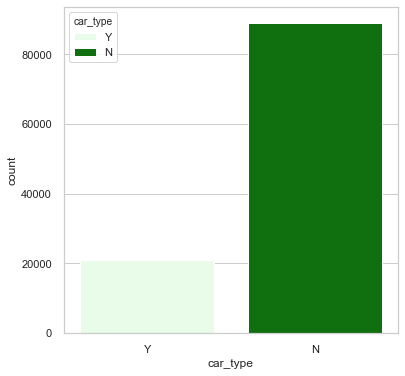

In [370]:
bar_count('car_type')

Только у 20% заёмщиков иномарка.

### Decline_app_cnt - количество отказанных прошлых заявок

0 : 83.04%
1 : 11.35%
2 : 3.29%
3 : 1.24%
4 : 0.55%
5 : 0.23%
6 : 0.14%
7 : 0.05%
8 : 0.03%
9 : 0.03%
10 : 0.01%
11 : 0.01%
12 : 0.0%
13 : 0.0%
14 : 0.0%
16 : 0.0%
30 : 0.0%
15 : 0.0%
19 : 0.0%
20 : 0.0%
21 : 0.0%
22 : 0.0%
24 : 0.0%
33 : 0.0%


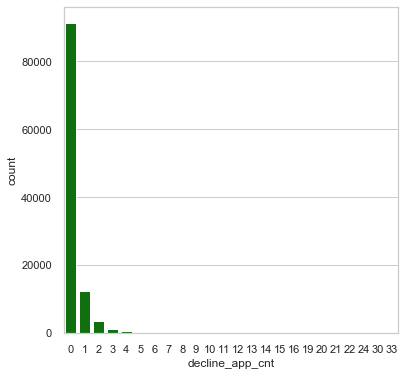

In [371]:
bar_count('decline_app_cnt', header=False)

In [372]:
emissions_analys('decline_app_cnt')

Минимальное значение: 0 | Максимальное значение: 33 Среднее значение: 0
25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | Границы выбросов: [0.0, 0.0]
Всего выбросов: 18677 | Выбросы в нижней границе: 0 | Выбросы в верхней границе: 18677


Распределение логнормальное, очень много единичных случаев с большим колиством заявок. Если просуммировать всё количество заявок больше 4 , то выйдет около 1 процента от количества всех заемщиков. Можно поступить следующими методами. 
* 1 Прологарифмировать, но это не сильно поможет, т.к. количество по 1 заявке.
* 2 Считать как выброс и удалить,но данных много и модель может получиться не полностью обученной.
* 3 Заменить все значения выше 4 на 4. Ограничим количество заявок.

0 : 83.04%
1 : 11.35%
2 : 3.29%
3 : 1.24%
4 : 1.08%


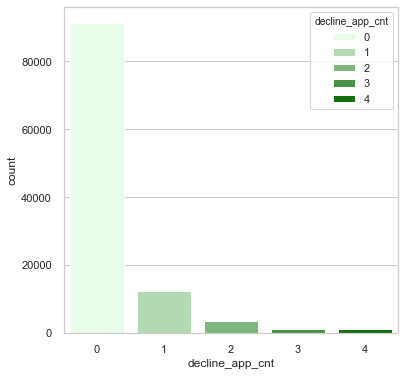

In [373]:
df.loc[df.decline_app_cnt > 4, 'decline_app_cnt'] = 4
bar_count('decline_app_cnt')

### Good_work - наличие хорошей работы

0 : 83.45%
1 : 16.55%


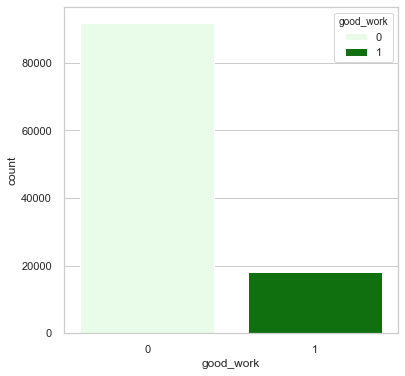

In [374]:
bar_count('good_work')

Хорошая работы только примерно у каждого пятого заемщика.

### Bki_request_cnt - количество запросов в БКИ

0 : 26.24%
1 : 24.78%
2 : 18.59%
3 : 12.41%
4 : 7.63%
5 : 4.5%
6 : 2.27%
7 : 1.17%
8 : 0.67%
9 : 0.42%
10 : 0.32%
11 : 0.25%
12 : 0.2%
13 : 0.14%
14 : 0.1%
15 : 0.07%
16 : 0.05%
17 : 0.03%
18 : 0.03%
19 : 0.03%
21 : 0.02%
20 : 0.01%
23 : 0.01%
24 : 0.01%
22 : 0.01%
25 : 0.0%
27 : 0.0%
28 : 0.0%
26 : 0.0%
32 : 0.0%
29 : 0.0%
33 : 0.0%
40 : 0.0%
41 : 0.0%
46 : 0.0%
45 : 0.0%
47 : 0.0%
36 : 0.0%
34 : 0.0%
53 : 0.0%


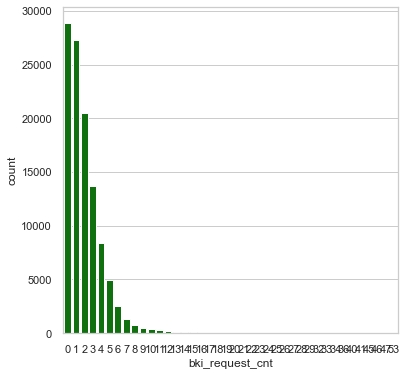

In [375]:
bar_count('bki_request_cnt', header=False)

Распределение логнормальное, посмотрим на выбросы.

In [376]:
emissions_analys('bki_request_cnt')

Минимальное значение: 0 | Максимальное значение: 53 Среднее значение: 2
25-й перцентиль: 0.0 | 75-й перцентиль: 3.0 | Границы выбросов: [-4.5, 7.5]
Всего выбросов: 2636 | Выбросы в нижней границе: 0 | Выбросы в верхней границе: 2636


In [377]:
df.loc[df.bki_request_cnt > 10, 'bki_request_cnt'] = 10

0 : 26.24%
1 : 24.78%
2 : 18.59%
3 : 12.41%
4 : 7.63%
5 : 4.5%
6 : 2.27%
10 : 1.31%
7 : 1.17%
8 : 0.67%
9 : 0.42%


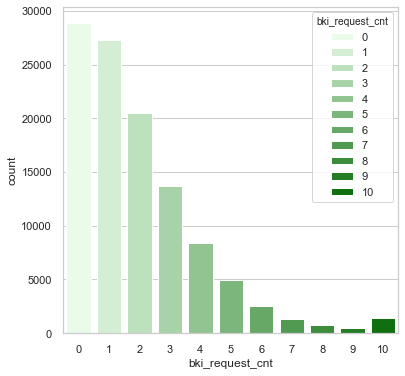

In [378]:
bar_count('bki_request_cnt')

In [379]:
dt['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

### Home_address - домашний адрес

2 : 54.1%
1 : 44.2%
3 : 1.7%


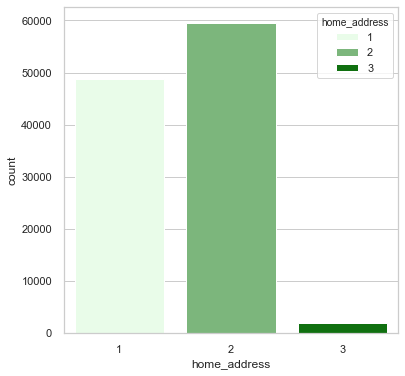

In [380]:
bar_count('home_address')

В основном все заемщики проживают в двух районах. В третьем примерно 2% от общего количества

### Work_address - рабочий адрес

3 : 60.93%
2 : 27.93%
1 : 11.14%


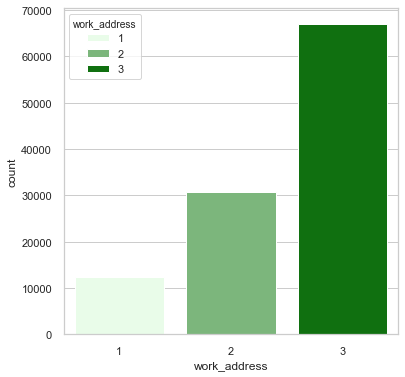

In [381]:
bar_count('work_address')

Больше половины работает в третьем районе, меньше всего в первом. Здесь уже появляется догадка что район №3 является промышленным или офисным районом города, что обусловленно большим притоком людей на работу и малым количеством проживающих здесь людей.

### Income - доход заемщика

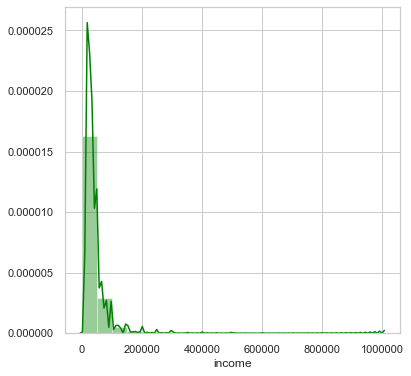

In [382]:
distplot(df, 'income', bins=20)

In [383]:
emissions_analys('income')

Минимальное значение: 1000 | Максимальное значение: 1000000 Среднее значение: 41012
25-й перцентиль: 20000.0 | 75-й перцентиль: 48000.0 | Границы выбросов: [-22000.0, 90000.0]
Всего выбросов: 7000 | Выбросы в нижней границе: 0 | Выбросы в верхней границе: 7000


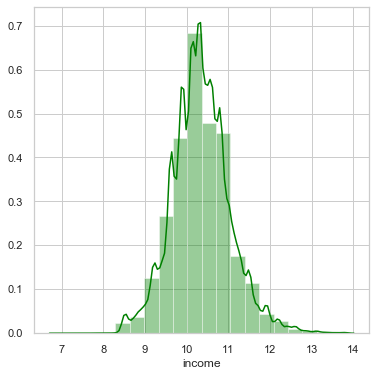

In [384]:
dt['income'] = np.log(df['income'] + 1)
distplot(dt, 'income', bins=20)

Выбросы есть но удалять их не стоит, возможно это люди, занимающие руководящие должности с очень высокими зарплатами.

### Посмотрим распределение доходов по районам проживания и работе

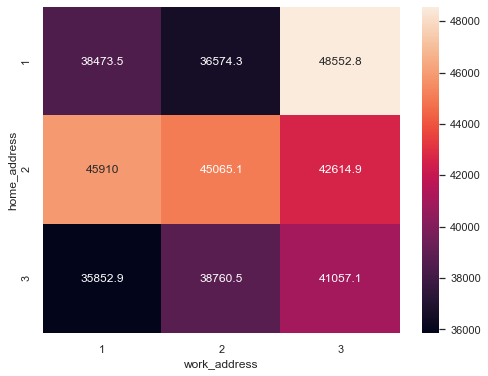

In [385]:
fig = plt.figure(figsize=(8,6))
incomes = df.groupby(['home_address', 'work_address'])['income'].mean()
sns.heatmap(incomes.unstack(), annot=True, fmt='g');

Из карты получается следующая ситуация:

* Доход в 3м районе работы чуть выше чем в других.
* Доход во втором районе жительства тоже выше чем в остальных.
* Самый большой доход в паре work_add = 3, home_addr = 1

Выводы:
* 1 - это центральная часть города для домашнего адреса, 3 - пригород или 1,2,3 - категории типа производство, офисные и пр.
* 1 - спальные районы для домашнего адреса, 3 - центральная часть

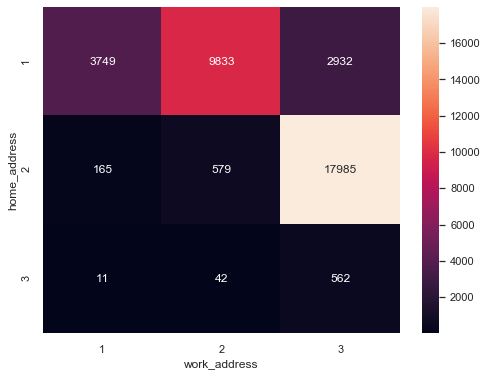

In [386]:
fig = plt.figure(figsize=(8,6))
cars = df[df.car=='Y'].groupby(['home_address', 'work_address'])['car'].count()
sns.heatmap(cars.unstack(), annot=True, fmt='g');

### Foreign_passport - наличие загранпаспорта

N : 85.09%
Y : 14.91%


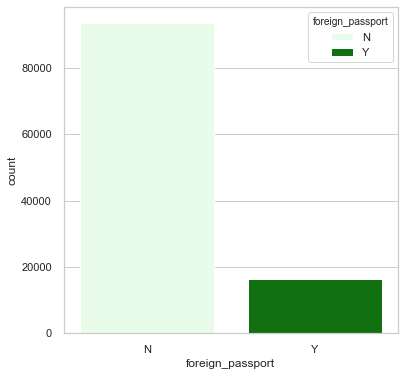

In [387]:
bar_count('foreign_passport')

### Sna - связь заемщика с клиентами банка

1 : 64.17%
4 : 15.87%
2 : 14.37%
3 : 5.59%


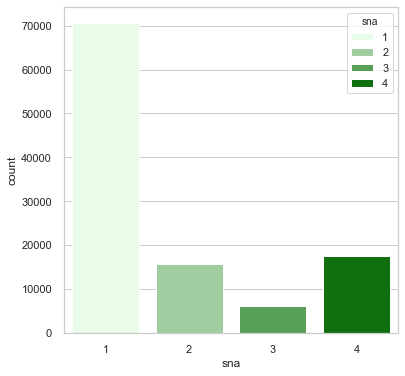

In [388]:
bar_count('sna')

### First_time - давность наличия информации о заемщике

3 : 42.3%
4 : 25.44%
1 : 16.61%
2 : 15.66%


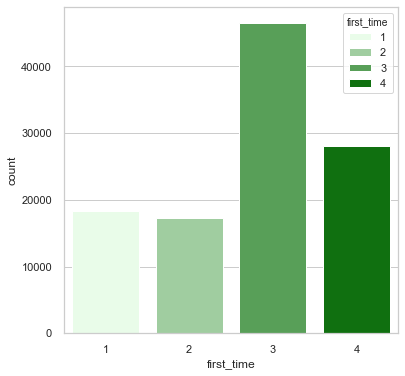

In [389]:
bar_count('first_time')

### Score_bki

In [390]:
emissions_analys('score_bki')

Минимальное значение: -3.62458632 | Максимальное значение: 0.19977285 Среднее значение: -1
25-й перцентиль: -2.2604336700000003 | 75-й перцентиль: -1.5678881525 | Границы выбросов: [-3.299251946250001, -0.5290698762499992]
Всего выбросов: 518 | Выбросы в нижней границе: 82 | Выбросы в верхней границе: 436


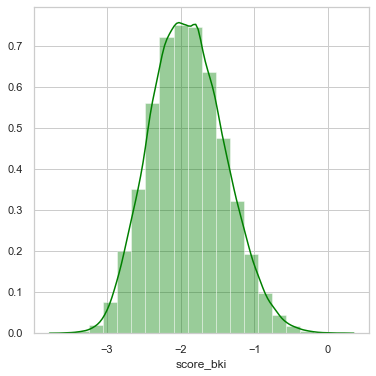

In [391]:
distplot(df, 'score_bki', bins=20)

In [393]:
# Распределение нормальное, выбросы есть, мы их удалим.
df = df[(df.score_bki <= -0.53) | (df.train == 0)]
df = df[(df.score_bki >= -3.3) | (df.train == 0)]

### region_rating - рейтинг региона

50 : 37.21%
60 : 21.79%
40 : 16.3%
80 : 15.58%
70 : 8.44%
30 : 0.39%
20 : 0.28%


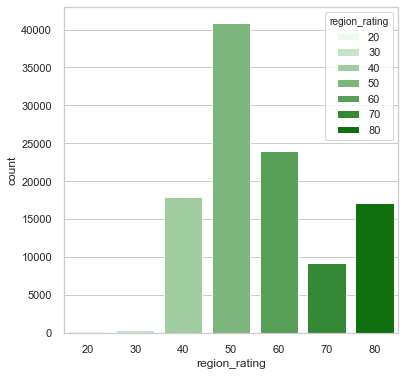

In [343]:
bar_count('region_rating')

In [344]:
emissions_analys('region_rating')

Минимальное значение: 20 | Максимальное значение: 80 Среднее значение: 56
25-й перцентиль: 50.0 | 75-й перцентиль: 60.0 | Границы выбросов: [35.0, 75.0]
Всего выбросов: 17879 | Выбросы в нижней границе: 745 | Выбросы в верхней границе: 17134


In [395]:
df = df[(df.region_rating >= 35) | (df.train == 0)]

### Default - наличие дефолта

0.0 : 58.36%
1.0 : 8.38%


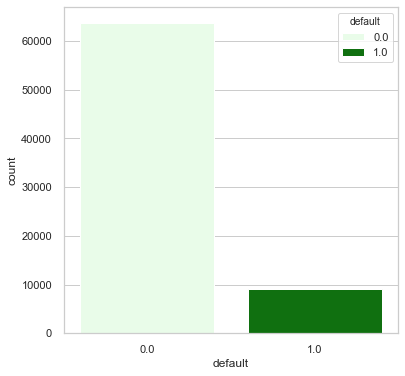

In [396]:
bar_count('default')

Примерно каждый 6-й заемщик не возвращает кредит.

# Оценка корреляций

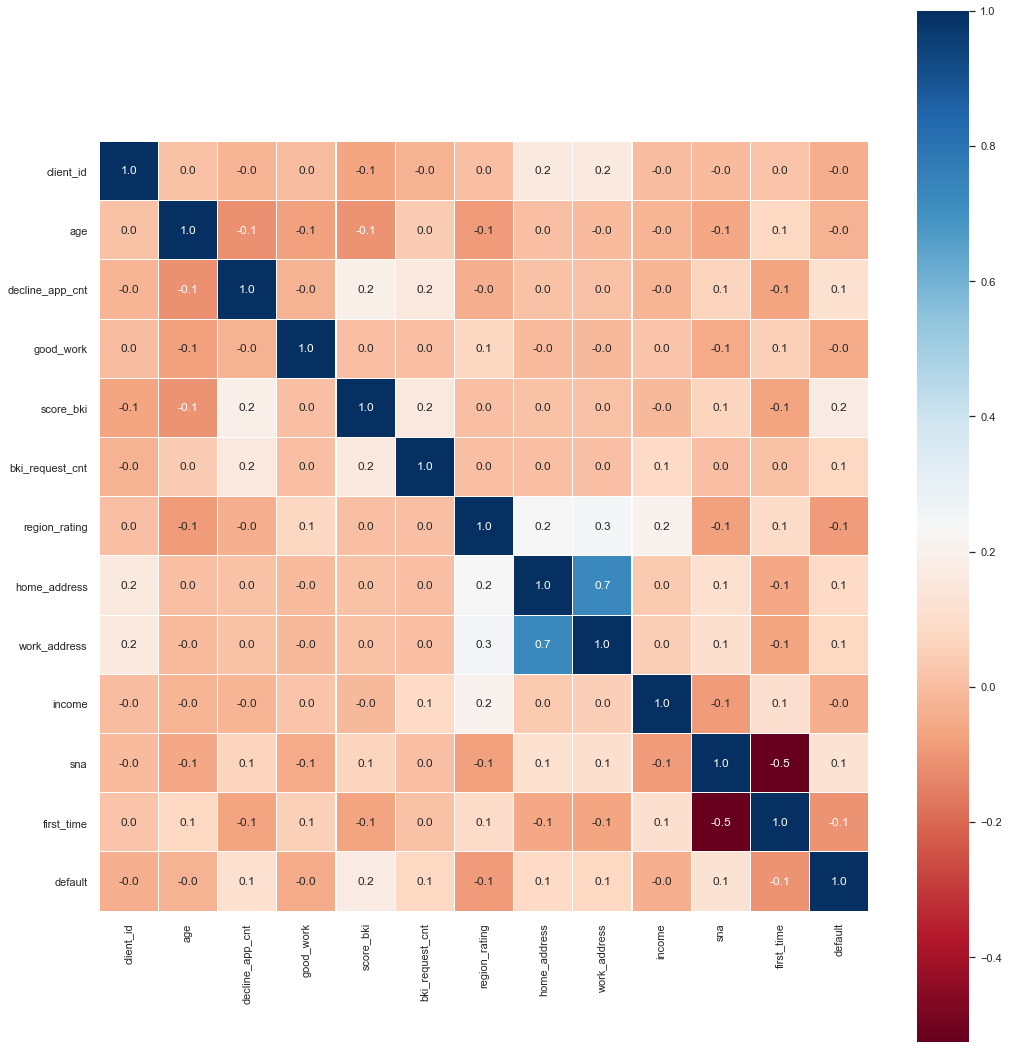

In [397]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

# Создание новых признаков (Feature Engeenering)

### Наличие автомобиля и иномарки - car
В датасете присутвуют 2 бинарных признака (car и car_type) которые отвечают за наличие автомобиля и является этот автомобиль иномаркой или нет. Вместо двух признаков изменим тип признака car на категориальный: 0 - нет авто, 1 - есть автомобиль (не иномарка) 2 - иномарка

In [398]:
df.loc[df.car=='N', 'car'] = 0
df.loc[df.car=='Y', 'car'] = 1
df.loc[df.car_type=='Y', 'car'] = 2
df.drop(columns=['car_type'], inplace=True)

### Район проживания и работы work_ home_address
Корреляционный анализ показывает, что признак как работа-проживание имеет сильную корреляцию и влияет на доход и наличие авто. Создадим общий признак, который назовем work_home.

In [399]:
df.loc[df.work_address==1, 'work_address'] = 'w1'
df.loc[df.work_address==2, 'work_address'] = 'w2'
df.loc[df.work_address==3, 'work_address'] = 'w3'

df.loc[df.home_address==1, 'home_address'] = 'h1'
df.loc[df.home_address==2, 'home_address'] = 'h2'
df.loc[df.home_address==3, 'home_address'] = 'h3'

df['work_home'] = df['work_address'] + df['home_address']

df.drop(columns=['home_address', 'work_address'], inplace=True)

### Сгруппируем признаки по типу: бинарные, категриальные, числовые

In [400]:
def data_category(df):   
        
    c_col = [col for col in df.columns if df[col].dtype.name == 'object' and df[col].nunique() > 2]
    n_col = [col for col in df.columns if df[col].dtype.name != 'object' and df[col].nunique() > 2]
    b_col = [col for col in df.columns if df[col].nunique() == 2]

    print(f'Количество категориальных признаков: {len(c_col)}')
    print(c_col)
    print(90*'=')
    print(f'Количество числовых признаков: {len(n_col)}')
    print(n_col)
    print(90*'=')
    print(f'Количество бинарных признаков: {len(b_col)}')
    print(b_col)
    return c_col, n_col, b_col

cat_cols, num_cols, bin_cols = data_category(df)

Количество категориальных признаков: 2
['car', 'work_home']
Количество числовых признаков: 11
['client_id', 'education', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time', 'days']
Количество бинарных признаков: 5
['sex', 'good_work', 'foreign_passport', 'default', 'train']


In [401]:
bin_cols = bin_cols[:3]
bin_cols

['sex', 'good_work', 'foreign_passport']

# Значимость непрерывных переменных по ANOVA F test

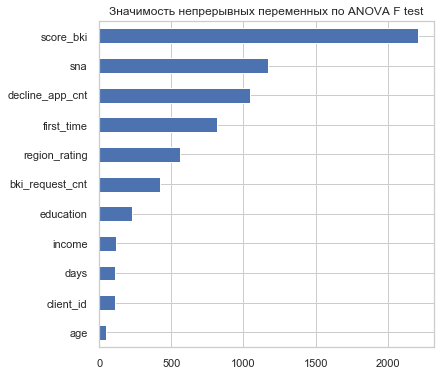

In [402]:
df_tr = df[df.train==1]
imp_num = Series(f_classif(df_tr[num_cols], df_tr['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
fig = plt.figure(figsize=(6,6))
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Самый значимый из признаков - оценка плательщика БКИ (score_bki). Самый незначительный признак - возраст (age) заемщика, id клиента и время со дня заявки (days)

# Значимость категориальных и бинарных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [403]:
# преобразуем в int
df.education = df.education.astype(int)

# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

df['work_home'] = label_encoder.fit_transform(df['work_home'])

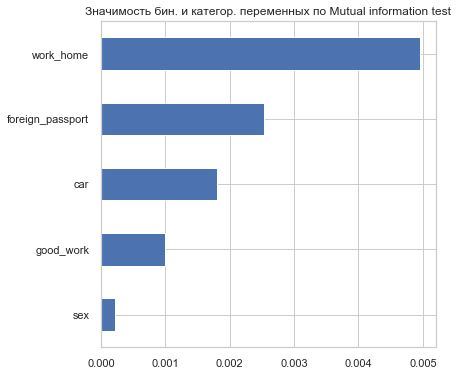

In [404]:
df_tr = df[df.train==1]
imp_cat = Series(mutual_info_classif(df_tr[bin_cols + cat_cols], df_tr['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
fig = plt.figure(figsize=(6,6))
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test');

# Машинное обучение

## Подготовка к машинному обучению

In [405]:
# StandardScaler отдельно для Train и Test для числовых значений
df.loc[df.train==1, num_cols] = StandardScaler().fit_transform(df.query('train==1')[num_cols].values)
df.loc[df.train==0, num_cols] = StandardScaler().fit_transform(df.query('train==0')[num_cols].values)

In [406]:
# Get_dummies для категорийных 
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [407]:
df

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,train,days,car_0,car_1,car_2,work_home_0,work_home_1,work_home_2,work_home_3,work_home_4,work_home_5,work_home_6,work_home_7,work_home_8
0,-0.918690,-0.817592,1,1.974403,-0.381429,0,-0.203101,-0.476038,-0.539524,-0.500754,2.019889,-1.748633,0,0.0,1,-0.935648,0,0,1,0,0,0,1,0,0,0,0,0
1,0.250746,-0.817592,0,1.713910,-0.381429,0,0.772537,0.520671,-0.539524,-0.479126,2.019889,-1.748633,0,0.0,1,0.277848,1,0,0,0,0,0,0,0,0,0,1,0
2,-0.919255,-0.817592,1,-1.238338,2.563594,0,1.026714,-0.476038,1.797813,-0.241225,-0.651909,1.220028,1,0.0,1,-0.935648,0,1,0,0,0,0,1,0,0,0,0,0
3,-1.222632,-0.817592,0,1.192925,-0.381429,0,-0.302857,0.022317,-0.539524,-0.673773,-0.651909,0.230475,0,0.0,1,-1.215686,1,0,0,0,0,0,0,0,0,0,1,0
4,1.459041,0.443763,1,0.758771,-0.381429,1,1.361333,-0.476038,0.239588,-0.241225,-0.651909,1.220028,1,0.0,1,1.429114,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0.909282,-0.819036,0,-0.189871,1.105908,0,0.317238,0.508897,-0.519845,-0.589836,2.027310,-1.745642,0,NaN,0,0.880432,1,0,0,0,0,0,0,0,0,0,1,0
110144,1.618273,0.439786,0,2.155284,-0.379630,0,-0.776530,0.508897,0.244303,3.633756,-0.649658,1.220114,0,NaN,0,1.662110,0,0,1,0,0,0,1,0,0,0,0,0
110145,0.848630,0.439786,1,-0.711016,2.591446,0,1.920053,-0.478000,-0.519845,0.437524,2.027310,-0.757057,0,NaN,0,0.849165,1,0,0,0,0,0,1,0,0,0,0,0
110146,-1.670829,1.698608,0,-1.058447,1.105908,0,1.318886,0.015449,1.772599,-0.247383,-0.649658,-1.745642,0,NaN,0,-1.714738,1,0,0,0,0,0,0,0,0,0,1,0


In [408]:
df.columns

Index(['client_id', 'education', 'sex', 'age', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'train', 'days', 'car_0',
       'car_1', 'car_2', 'work_home_0', 'work_home_1', 'work_home_2',
       'work_home_3', 'work_home_4', 'work_home_5', 'work_home_6',
       'work_home_7', 'work_home_8'],
      dtype='object')

## Построение модели

In [409]:
train = df.query('train == 1').drop(['train', 'client_id'], axis=1)
test = df.query('train == 0').drop(['train', 'client_id'], axis=1)

X = train.drop(['default'], axis=1)
y = train.default.values

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test.shape, train.shape, X.shape, X_train.shape, X_test.shape

((36349, 26), (72956, 26), (72956, 25), (58364, 25), (14592, 25))

## Логистическая регрессея

In [410]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=100, solver='liblinear')

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

# Оценка качества модели

## Метрики

In [411]:
print_metrics()

Accuracy: 0.8757
Precision: 0.4434
Recall: 0.0261
F1: 0.0493


## Матрица ошибок

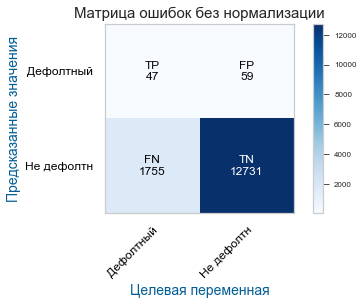

In [412]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

## ROC-AUC Кривая

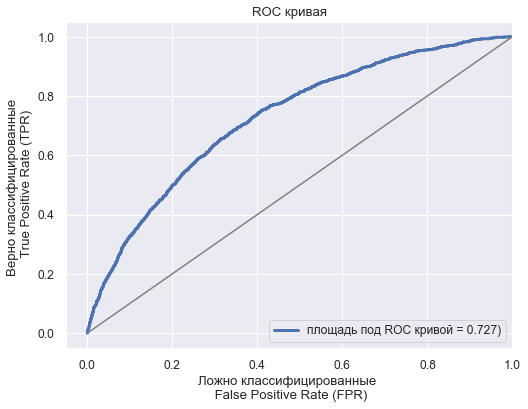

In [413]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

Несмотря на хорошие показатель ROC-AUC мы очень плохо угадали дефолтных клинетов, что видно по confusion-matrix и метрике F1

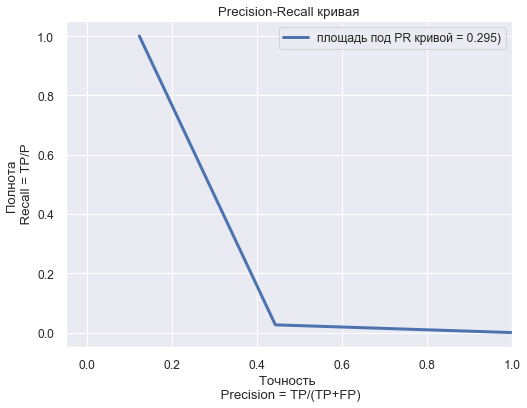

In [414]:
PR_curve_with_area(y_test, y_pred, 1.1)

## Кросс-валидация

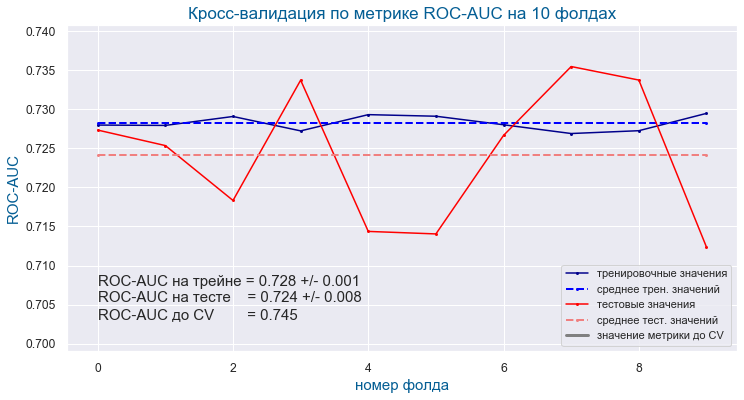

In [415]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

### Промежуточный вывод
Модель получилась очень плохая, несмотря на высокое значений Roc-Auc, мы неугадали дефолтных клиентов (предсказано верно всего 47), об этом свидетельствует низкое значение метрики recall = 0.0261. Большинство клиентов попало в "ошибку второго рода", это означает что банк будет выдавать деньги глиентам, которые не смогут их вернуть.
Целевая метрика численно получилась хорошей, но не отражает суть. Для этого добавлена кривая precision-recall , площадь под которой получилась очень маленькой. Что показывает, что точность нашего алгоритма маленькая...

# Поиск оптимальных параметров модели

## GridSearch(1)

Запускаем на небольшом количестве итераций max_iter = 50 с достаточно большой дельтой останова tol1e-3

In [416]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
   # {'penalty': ['l2'], 
   #  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
   #  'class_weight':['none', 'balanced'], 
   #  'multi_class': ['auto','ovr'], 
   #  'max_iter':[iter_],
   #  'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_


best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6700
Precision: 0.2218
Recall: 0.6665
F1: 0.3328


Метрика f1 подросла примерно в 9 раз. Построим модель на этих параметрах и посмотрим как это улучшит модель

In [428]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= -1, 
                           penalty= 'none', 
                           solver = 'newton-cg', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print_metrics()

Accuracy: 0.6671
Precision: 0.2187
Recall: 0.6593
F1: 0.3284


## Оценка качества оптимизированной модели

### Матрица ошибок

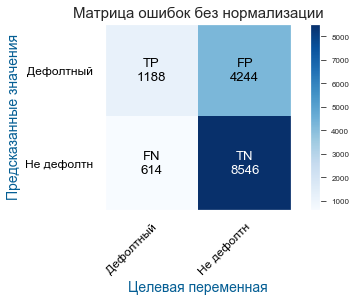

In [429]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

### ROC-AUC Кривая

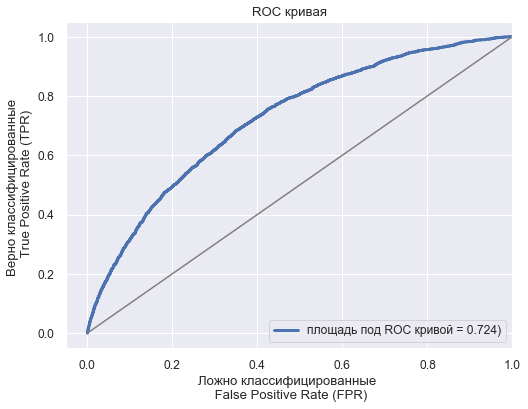

In [430]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

### Precision-Recall кривая

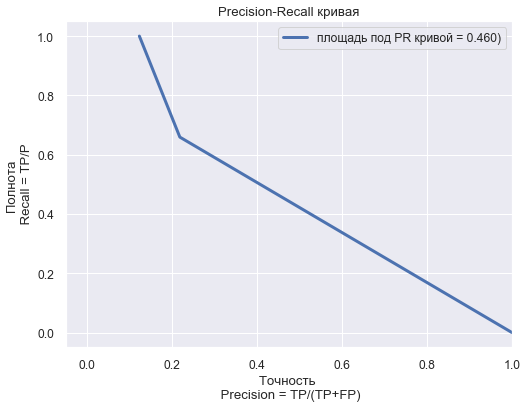

In [431]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

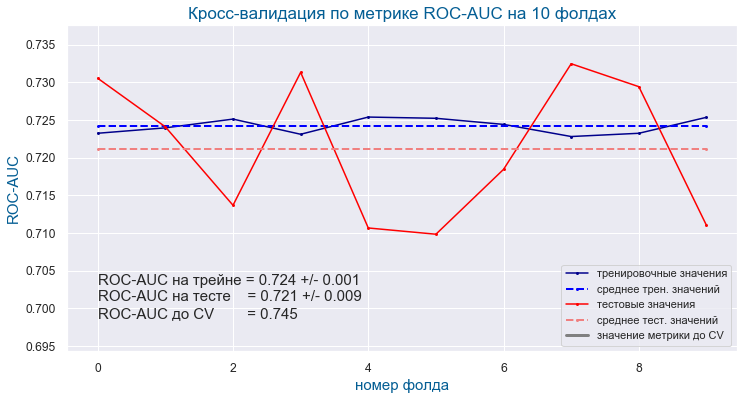

In [432]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

### Сравнение с предыдущей моделью
Recall (до 0.66 с 0.022) и f1 (до 0.33) заметно выросли, Precision, Accuracy упали, ROC-AUC остался почти на том-же месте. Мы можем ожидать уменьшение ошибки второго рода, что видно из матрицы. Модель должна лучше себя вести на менее сбалансированных данных. Дисперсия не изменилась на кросс-валидации, так-что можно еще можно попробовать оптимизировать модель: подобрать параметры или убрать некоторые признаки.

## Проверка нулевых коэффициентов при регуляризации первого порядка

Регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки, которые не нравятся модели (в них могут быть выбросы или неподходящий формат) может это поможет избавиться от большой дисперсии при кросс-валидации

In [433]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

display(model_coef(X_train.columns, model.coef_[0]))

,имя признака,коэффициент модели
0,work_home_2,-2.463339
1,work_home_1,-0.978499
2,work_home_0,-0.528319
3,score_bki,0.493210
4,work_home_7,0.435016
5,car_2,-0.376220
6,region_rating,-0.360203
7,foreign_passport,-0.330429
8,sex,0.302481
9,good_work,-0.288334


Удаляем последних 10 метрик начиная со sna_3 до education_2. Создаем список на удаление

In [434]:
drop_list1 = ['car_0','work_home_4','car_1','work_home_8','income','age','education','first_time',
              'work_home_5','days']

In [435]:
train = df.query('train == 1').drop(['train', 'client_id']+drop_list1, axis=1)
test = df.query('train == 0').drop(['train', 'client_id']+drop_list1, axis=1)

X = train.drop(['default'], axis=1)
y = train.default.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Проверка качества модели после удаления признаков

In [436]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= -1, 
                           penalty= 'none', 
                           solver = 'newton-cg', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6636
Precision: 0.2154
Recall: 0.6526
F1: 0.3239


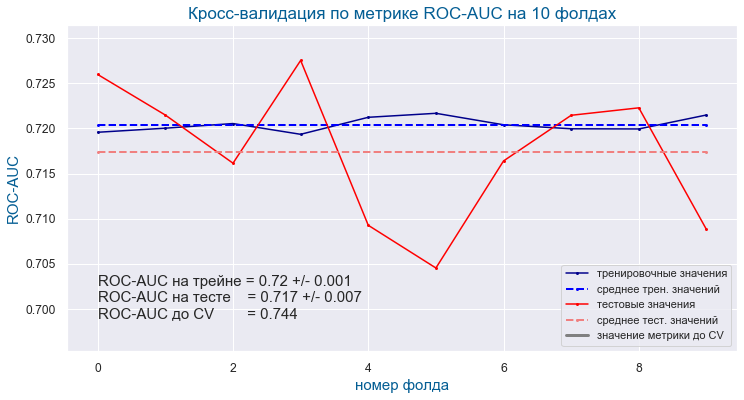

In [437]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

Дисперсия в кросс-валидации не изменилась, метрики F1, Recall, Precision возросли на тысячные.

## Поиск оптимальных параметров модели

Запускаем GridSearch CV с расширенным набором параметров.
примечание блок закомментирован, т.к выполняется долго

In [438]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced', random_state=RANDOM_SEED)

param_grid = [
    {'penalty': ['l1'], 'C':[0.02, 0.1, 0.2, 0.5, 1, 3, 10], 'max_iter':[1000],'tol':[1e-5], 'solver':['liblinear', 'saga']},
    {'penalty': ['l2'], 'C':[0.02, 0.1, 0.2, 0.5, 1, 3, 10], 'max_iter':[1000],'tol':[1e-5], 'solver':['newton-cg', 'lbfgs', 'sag', 'saga']},
    {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5], 'solver':['lbfgs', 'newton-cg']}]
gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_



##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

##печатаем метрики
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 1e-05
	verbose: 0
	warm_start: False
Accuracy: 0.6636
Precision: 0.2154
Recall: 0.6526
F1: 0.3239


### Третья модель

In [439]:
model = LogisticRegression(C=2.15, 
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='saga', 
                           random_state=RANDOM_SEED,
                           max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.6636
Precision: 0.2154
Recall: 0.6526
F1: 0.3239


### Финальные метрики

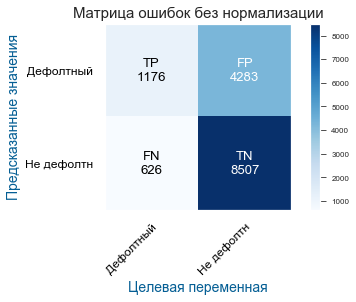

In [440]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

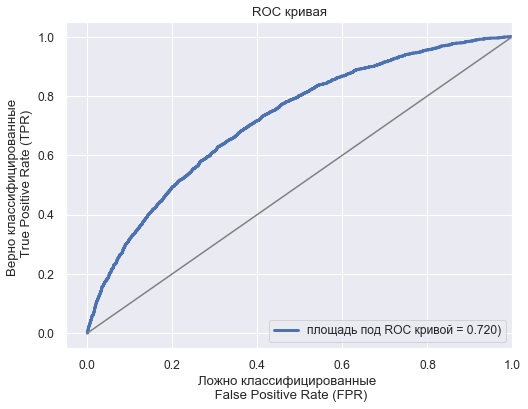

In [441]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

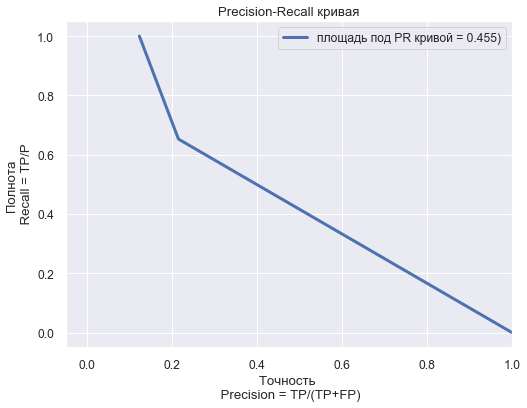

In [442]:
PR_curve_with_area(y_test, y_pred, 1.1)

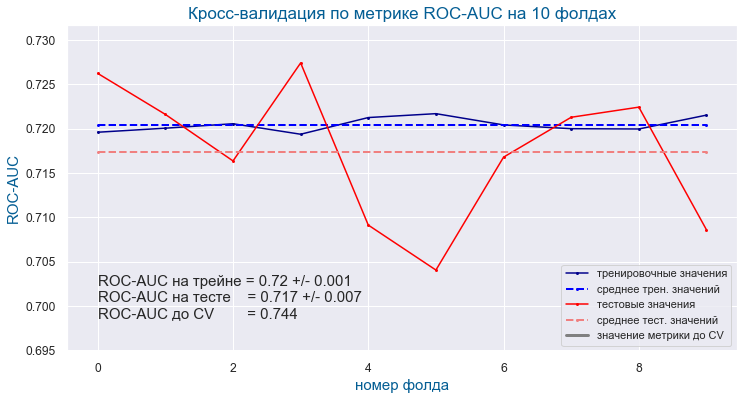

In [444]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
vis_cross_val_score('ROC-AUC', temp_vec, 0.744262, 1.1)

# SUBMISSION

In [445]:
train = df.query('train == 1').drop(['train', 'client_id']+drop_list1, axis=1)
test = df.query('train == 0').drop(['train', 'client_id']+drop_list1, axis=1)

In [446]:
X_train=train.drop(['default'], axis=1)
y_train = train.default.values
X_test = test.drop(['default'], axis=1)

In [447]:
test.shape, train.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 16), (72956, 16), (72956, 15), (72956,), (36349, 15))

In [448]:
LogisticRegression(C=2.15, 
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='saga', 
                           random_state=RANDOM_SEED,
                           max_iter = 2000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]

In [449]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [93]:
submit.to_csv('submission.csv', index=False)